In [1]:
import glob, os, pysam
from collections import defaultdict, Counter
import numpy as np
import pandas as pd
from scipy.stats import ttest_ind
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
from matplotlib_venn import *
import seaborn as sns
from pyBioInfo.Range import GRange
from pyBioInfo.IO.File import BamFile

# Report mismatch ratio

In [6]:
infos = pd.read_excel("NanoNASCseq_summary.xls")

# Loading mismatch ratio
data1 = dict() # ME
data2 = dict() # CE
for run, cell in infos[["Run", "Cell"]].values:
    path = "results/mismatch/ratio/%s/%s/ratio.me.tsv" % (run, cell)
    if os.path.exists(path):
        d = pd.read_csv(path, sep="\t", index_col=0)
        data1[cell] = d
    path = "results/mismatch/ratio/%s/%s/ratio.ce.tsv" % (run, cell)
    if os.path.exists(path):
        d = pd.read_csv(path, sep="\t", index_col=0)
        data2[cell] = d

In [7]:
dat = infos[infos["Reads"] >= 50000]
array = []
for run, tmp1 in dat.groupby(by="Run"):
    for strain, tmp2 in tmp1.groupby(by="Strain"):
        for su, tmp3 in tmp2.groupby(by="s4U"):
            for time, tmp4 in tmp3.groupby(by="Time"):
                d1 = tmp4[np.isnan(tmp4["ActD"])]                
                if len(d1) > 0:
                    array.append(["%s.%s.%03duM_%.2fh" % (run, strain, su, time), d1["Cell"].values])
                d2 = tmp4[~np.isnan(tmp4["ActD"])]
                if len(d2) > 0:
                    for actd, d3 in d2.groupby(by="ActD"):
                        array.append(["%s.%s.%03duM_%.2fh_ActD%dh" % (run, strain, su, time, actd), d3["Cell"].values])

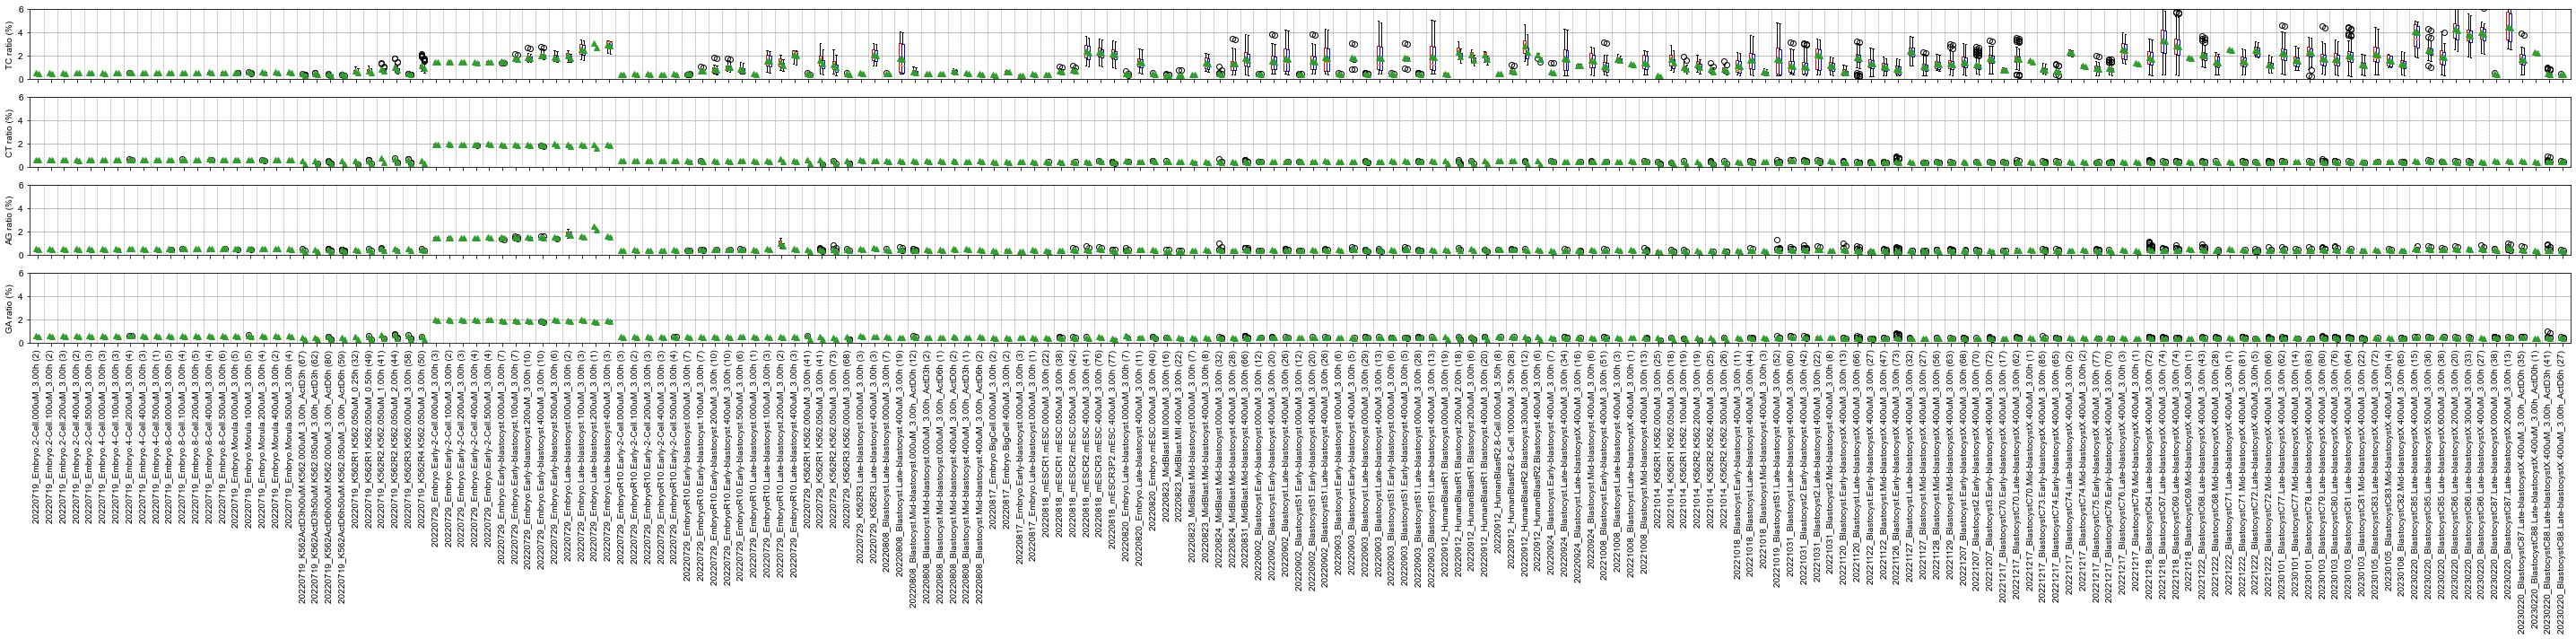

In [8]:
fig, axs = plt.subplots(4, 1, figsize=(40, 10), sharex=True, sharey=True)
mtypes = ["TC", "CT", "AG", "GA"]
for i, mtype in enumerate(mtypes):
    values1 = []
    for item in array:
        vs = []
        for cell in item[1]:
            if cell in data1:
                r = data1[cell].loc[mtype]["Ratio"] * 100
                vs.append(r)
        values1.append(vs)
    values2 = []
    for item in array:
        vs = []
        for cell in item[1]:
            if cell in data2:
                r = data2[cell].loc[mtype]["Ratio"] * 100
                vs.append(r)
        values2.append(vs)
    plt.sca(axs[i])
    xs = np.arange(len(array))
    xticks = ["%s (%d)" % (item[0], len(item[1])) for item in array]
    plt.boxplot(values1, positions=xs - 0.1, widths=0.2, boxprops={"color": "red"}, showmeans=True)
    plt.boxplot(values2, positions=xs + 0.1, widths=0.2, boxprops={"color": "blue"}, showmeans=True)
    plt.ylim(0, 6)
    for x in xs:
        if x != 0:
            plt.axvline(x - 0.5, ls="--", lw=0.5, color="grey")
    if i == 3:
        plt.xticks(xs, xticks, rotation=90)
    plt.grid(axis="y")
    plt.ylabel("%s ratio (%%)" % mtype)
    plt.tight_layout()
    
# plt.show()
plt.savefig("figures/mismatch_ratio.all_runs.pdf", dpi=300)